# Distal Events Table

__Description__: Excess rainfall is calculated for ...
    
__Input__: The metadata *.json* file from either `EventsTable.ipynb` or `PM-EventsTable.ipynb`, which contains the final precipitation curves for each randomized event.

__Output__:
    
---

## A. Load Libraries, Parameters, and Data:

### Libraries:

In [1]:
import sys
sys.path.append('core')
from hydromet import*

### Parameters:

#### Papermill (site specific):

In [2]:
## Excess rainfall parameters:
CN = 85  # Curve number


## Filenames and paths:
AOI = 'DC'     # Area of interest
Model = 'P01'  # Model name

root_dir = pl.Path(os.getcwd())
outputs_dir = root_dir/'Outputs'
datarepository_dir = root_dir/'DataRepository'


## Options:
display_print = True

##### Convert all paths to objects:

In [3]:
outputs_dir = pl.Path(outputs_dir)
datarepository_dir = pl.Path(datarepository_dir)

#### Global (project specific):

In [4]:
## Filenames and paths:
CN_Distribution = 'NEH630_Table_10_1.json'


## Options:
adjust_CN_less24 = False # Set to True to adjust the curve number when the storm duration is less than 24 hours
papermill = False

start_time = time.time()

###  Data:

#### Metadata from EventsTable.ipynb:

In [5]:
with open(outputs_dir/'Metadata_{0}_{1}.json'.format(AOI, Model)) as f:
    md = json.load(f)

##### Extract the durations:

In [6]:
durations = list(md.keys())
print('Durations:', durations)

Durations: ['H06', 'H12', 'H24', 'H96']


##### Extract the boundary condition names:

In [7]:
BCN = list(md[durations[0]]['BCName'].keys())
print('Boundary Condition Names:', BCN)

Boundary Condition Names: ['D01']


#### Curve number distribution:

In [8]:
arc_data = get_CN_distribution(datarepository_dir, CN_Distribution, CN, display_print)

{'Dry': 70, 'Wet': 94}


---

## B. TBD

In [ ]:
for dur in durations:
    for name in BCN:

In [9]:
dur = durations[2]
idur = int(dur.replace('H', ''))
name = BCN[0]

,Random CN
1,81
2,72


None
CN - Seed: 3537


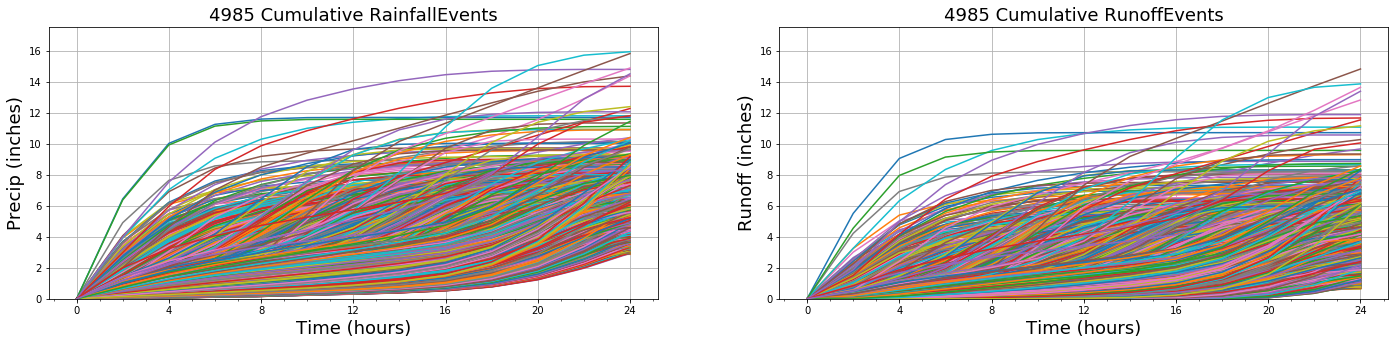

In [10]:
################# make modular:
outfiles = []

scen = md[dur]['BCName'][name]

groups = scen['groups']

precip = scen['precip']

metadata = scen['events_metadata']
eventID = metadata['EventID']
n_rand_events = len(eventID.keys())

params = scen['parameters']
seed = params['seed']
tempEpsilon = params['tempEpsilon']
tempEpsilon2 = params['tempEpsilon2']
convEpsilon = params['convEpsilon']
volEpsilon = params['volEpsilon']


## Calculate random curve numbers:
df_CN = prep_cn_table(CN, arc_data) 
fitted_cn = find_optimal_curve_std(df_CN, 'Lower', 'Upper')
filename = "Rand_CN_distal_{0}_Dur{1}_tempE{2}_convE{3}_volE{4}_Se{5}.csv".format(AOI, idur, tempEpsilon, convEpsilon, volEpsilon, seed)
outfiles.append(filename)
random_cns = RandomizeData(fitted_cn, n_rand_events, outputs_dir, filename, seed=seed, variable='CN', lower='Lower', upper='Upper', display_print = display_print)


## Peform the excess rainfall calculation:
runids = []
events_log = {}
count = 0
for k, v in eventID.items():
    if count == 0:
        idx = [float(i) for i in list(precip[v].keys())]
        final_precip = pd.DataFrame(index = idx)
        cum_excess = pd.DataFrame(index = idx)
        incr_excess = pd.DataFrame(index = idx)
        count+=1
    excess = []
    cum_precip = list(precip[v].values())
    total_precip = cum_precip[-1]
    cn = random_cns.loc[int(k)]['Random CN']
    if idur < 24 and adjust_CN_less24:
        adj_cn, s, ia = update_CN(cn, idur, total_precip)
    else:
        s  = S_24hr(cn)
        ia = IA_24hr(s)
    for p in cum_precip:
        excess.append(calculate_excess(p, ia, s))
    runid = 'E{}_'.format(int(k))+'{}Hr_'.format(idur)+'Q{}_'.format(metadata['Quartile'][k])+'D{}_'.format(metadata['Decile'][k])+'CN{}'.format(cn)
    events_log[v] = runid
    cum_excess[v] = excess
    final_precip[v] = cum_precip
    incr_excess[v] = adjust_incremental(final_precip[v], cum_excess[v])
    
f0 = plot_rainfall_and_excess(final_precip, cum_excess, idur, iplot = papermill)   

In [19]:
final_curves = calc_mean_curves(groups, incr_excess) 

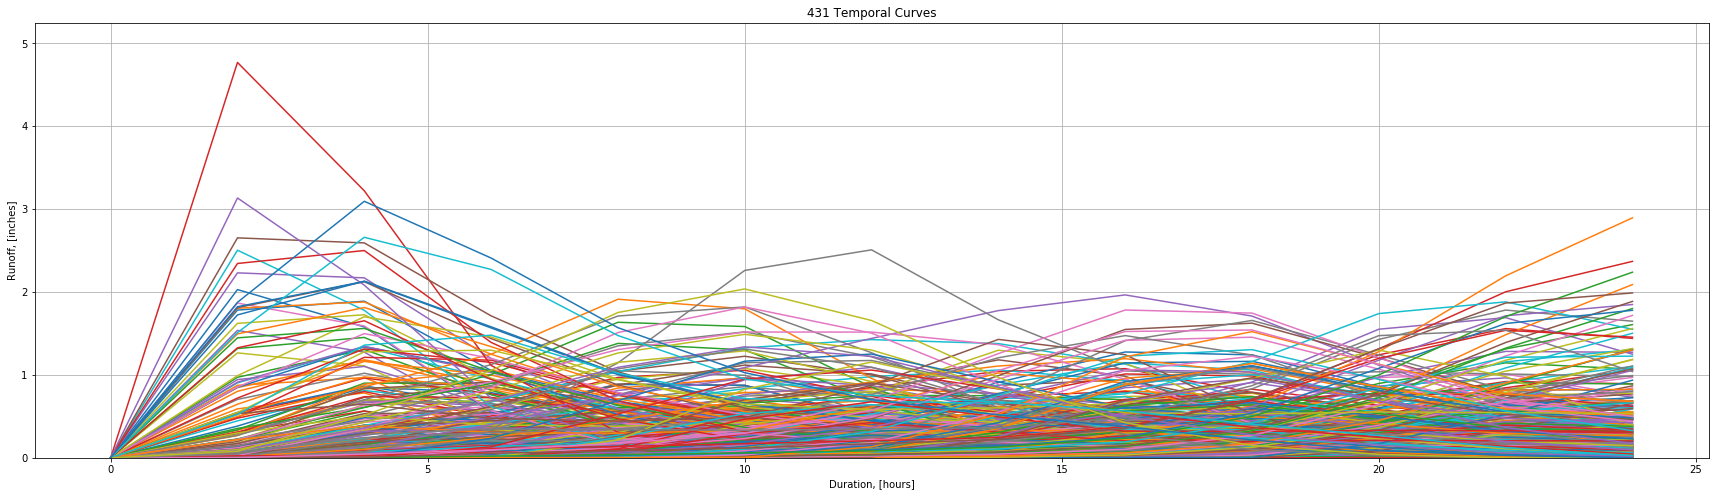

In [33]:
#### Plot the combined temporal curves:
y_max = final_curves.max().max()

f2 = plot_grouped_curves(final_curves, y_max, iplot = papermill)

In [ ]:
####Save the Results:

final_curves.to_csv(outputs_dir/'Excess_Rainfall_distal_{0}_Dur{1}_tempE{2}_convE{3}_volE{4}.csv'.format(AOI, duration, tempEpsilon, convEpsilon, volEpsilon))

metadata = {}

metadata['groups'] = dic_key_to_str(renamed_groups)
metadata['test_stat'] = dic_key_to_str(renamed_tests)
metadata['precip'] = final_precip.to_dict()
metadata['cum_excess'] = cum_excess.to_dict()
metadata['incr_excess'] = incr_excess.to_dict()
metadata['parameters'] = {'seed': seed, 'tempEpsilon': tempEpsilon, 'tempEpsilon2': tempEpsilon2, 'convEpsilon': convEpsilon, 'volEpsilon': volEpsilon}
metadata['events_metadata'] = extract_event_metadata(outfiles, events_metadata,  outputs_dir, remove_intermediates)

with open(os.path.join(str(outputs_dir.resolve()),'Metadata_{0}_Dur{1}_tempE{2}_convE{3}_volE{4}.json'.format(AOI, duration, tempEpsilon, convEpsilon, volEpsilon)), 'w') as f:
    json.dump(metadata, f)
    
if display_print: print('Runtime: {} Minutes'.format(round(time.time()-start_time)/60, 3))  

---

# End